
<center>

# <u>Melanoma Cancer Detection using CNN</u>

# Multiclass Classification Model
  using a custom
# Convolutional Neural Network in TensorFlow

    
</center>

<strong>Problem statement:</strong> To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

* Actinic keratosis
* Basal cell carcinoma
* Dermatofibroma
* Melanoma
* Nevus
* Pigmented benign keratosis
* Seborrheic keratosis
* Squamous cell carcinoma
* Vascular lesion

## Importing Libraries

In [1]:
import pathlib
import tensorflow as tf    # !pip install tensorflow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive
import seaborn as sns
from glob import glob

In [2]:
# Mount google drive
# Note that this will ask you to authenticate your google account and grant permission to Colab to access your google Drive.
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

#### Check the number of training images

In [11]:
len(list(data_dir_train.glob('*/*.jpg')))

2239

#### Check the number of test images

In [12]:
len(list(data_dir_test.glob('*/*.jpg')))

118

## Create a dataset
Define some parameters for the loader:

In [13]:
my_batch_size = 32
my_img_height = 180
my_img_width = 180

### Let's load the images using the helpful image_dataset_from_directory utility. <br/>
Splitting training Images into the training and validation datasets in 80:20 ratio. <br/>


<strong>Creating training dataset (80%)</strong>

In [16]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               batch_size=my_batch_size,
                                                               image_size=(my_img_height,my_img_width),
                                                               label_mode='categorical',
                                                               seed=123,
                                                               subset="training",
                                                               validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


<strong>Creating validation dataset (20%)</strong>

In [17]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               batch_size=my_batch_size,
                                                               image_size=(my_img_height,my_img_width),
                                                               label_mode='categorical',
                                                               seed=123,
                                                               subset="validation",
                                                               validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [18]:
# Let us print all the classes of skin cancer and store them in a list.
# The class names can be found in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

## Visualize the data

### Let us use the training dataset to view the first instance of all the classes

In [19]:
# As per the class the image path will be stored in the respective directory
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

files_path_dict


{'actinic keratosis': ['/content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026626.jpg',
  '/content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026149.jpg',
  '/content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025825.jpg',
  '/content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0029210.jpg',
  '/content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0029713.jpg',
  '/content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0027950.jpg',
  '/content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The International Skin I

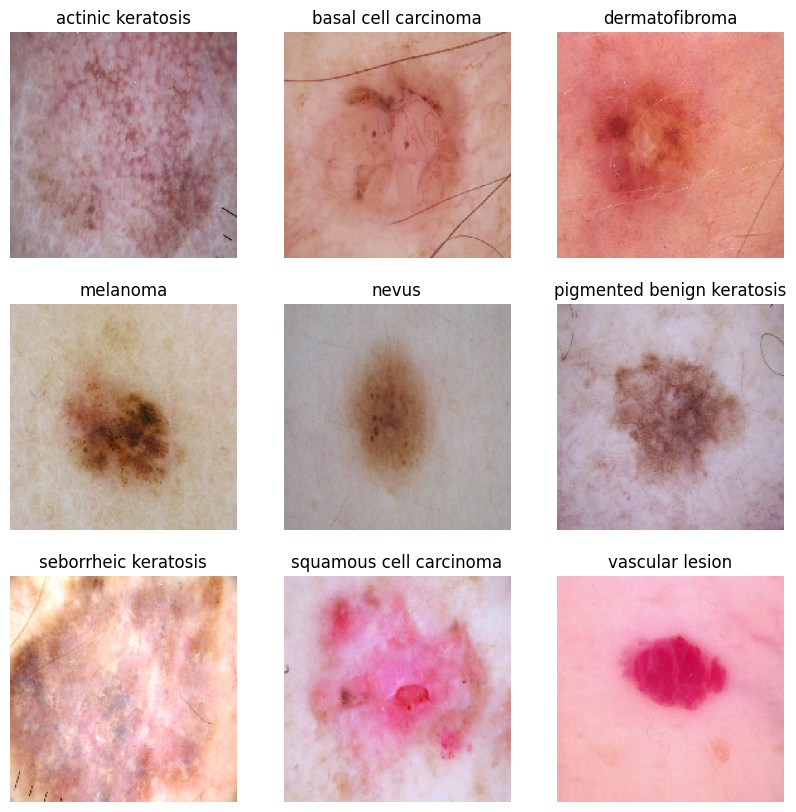

In [20]:
# Let us print one image from all the classes
plt.figure(figsize=(10,10))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(keras.preprocessing.image.load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`tf.data.experimental.AUTOTUNE` defines appropriate number of processes that are free for working.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the Model

Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [22]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))

model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Dropout(0.5))

model.add(layers.Flatten())

model.add(layers.Dense(128,activation='relu'))

model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))

## Compile the Model

In [23]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

## Training the Model

In [24]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 386s 1s/step - loss: 2.0487 - accuracy: 0.2182 - val_loss: 1.9024 - val_accuracy: 0.4072
Epoch 2/20
56/56 [==============================] - 3s 56ms/step - loss: 1.7341 - accuracy: 0.3934 - val_loss: 1.5843 - val_accuracy: 0.4877
Epoch 3/20
56/56 [==============================] - 3s 53ms/step - loss: 1.6018 - accuracy: 0.4408 - val_loss: 1.4580 - val_accuracy: 0.5168
Epoch 4/20
56/56 [==============================] - 3s 51ms/step - loss: 1.4475 - accuracy: 0.4983 - val_loss: 1.4454 - val_accuracy: 0.4832
Epoch 5/20
56/56 [==============================] - 3s 51ms/step - loss: 1.3959 - accuracy: 0.5134 - val_loss: 1.4210 - val_accuracy: 0.5414
Epoch 6/20
56/56 [==============================] - 3s 51ms/step - loss: 1.3380 - accuracy: 0.5312 - val_loss: 1.4959 - val_accuracy: 0.4877
Epoch 7/20
56/56 [==============================] - 3s 57ms/step - loss: 1.3096 - accuracy: 0.5452 - val_loss: 1.3757 - val_accuracy: 0.5257
Epoch 8/20
56

## Visualizing the training results

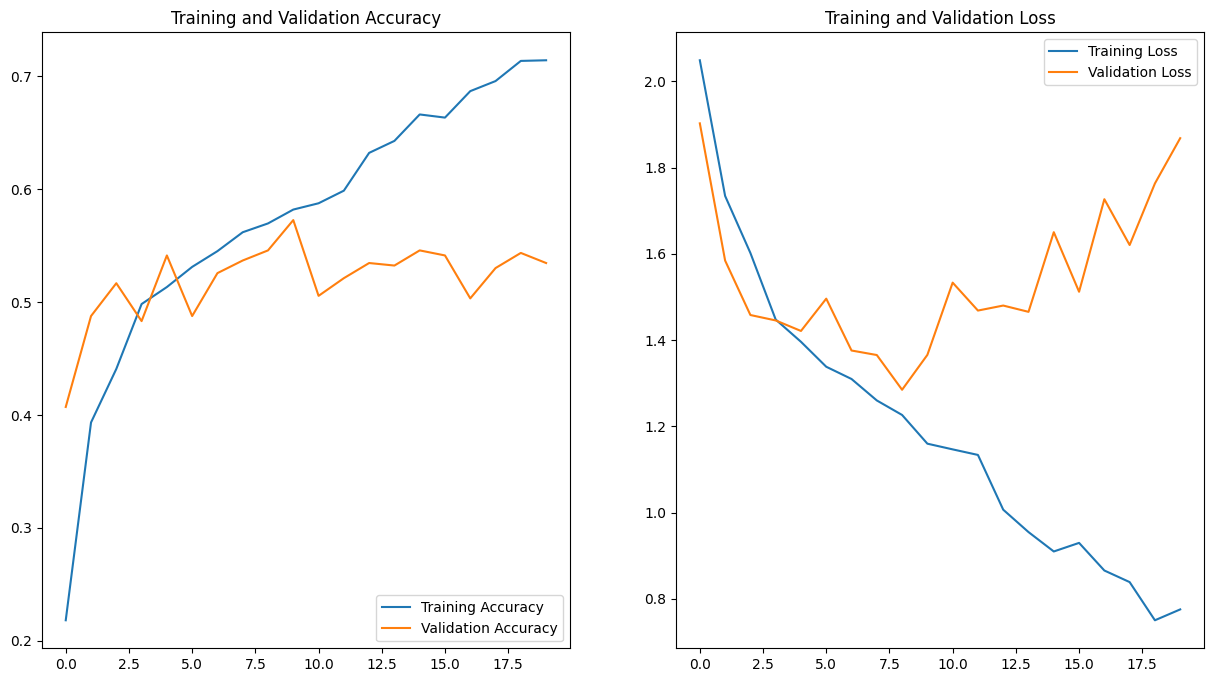

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observation:
The above chart shows that our current model is performing well during training phase, however, it is performing bad during Validation phase. This clearly shows that our model is overfitting.

Let us view the image count in each of the classes in the training dataset.

In [28]:
count = []

for path in pathlib.Path(data_dir_train).iterdir():
    if path.is_dir():
        count.append(len([name for name in os.listdir(path)
                            if os.path.isfile(os.path.join(path, name))]))

sub_directory = [name for name in os.listdir(data_dir_train)
    if os.path.isdir(os.path.join(data_dir_train, name))]

In [29]:
count

[114, 376, 95, 438, 357, 462, 77, 181, 139]

In [30]:
sub_directory

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

Let us create a dataframe

In [31]:
Images_by_Count_df = pd.DataFrame(list(zip(sub_directory,count)),columns=["Class","Image Count"])
Images_by_Count_df

Class  Image Count
0           actinic keratosis          114
1        basal cell carcinoma          376
2              dermatofibroma           95
3                    melanoma          438
4                       nevus          357
5  pigmented benign keratosis          462
6        seborrheic keratosis           77
7     squamous cell carcinoma          181
8             vascular lesion          139

Let us create a barchart from above DataFrame.

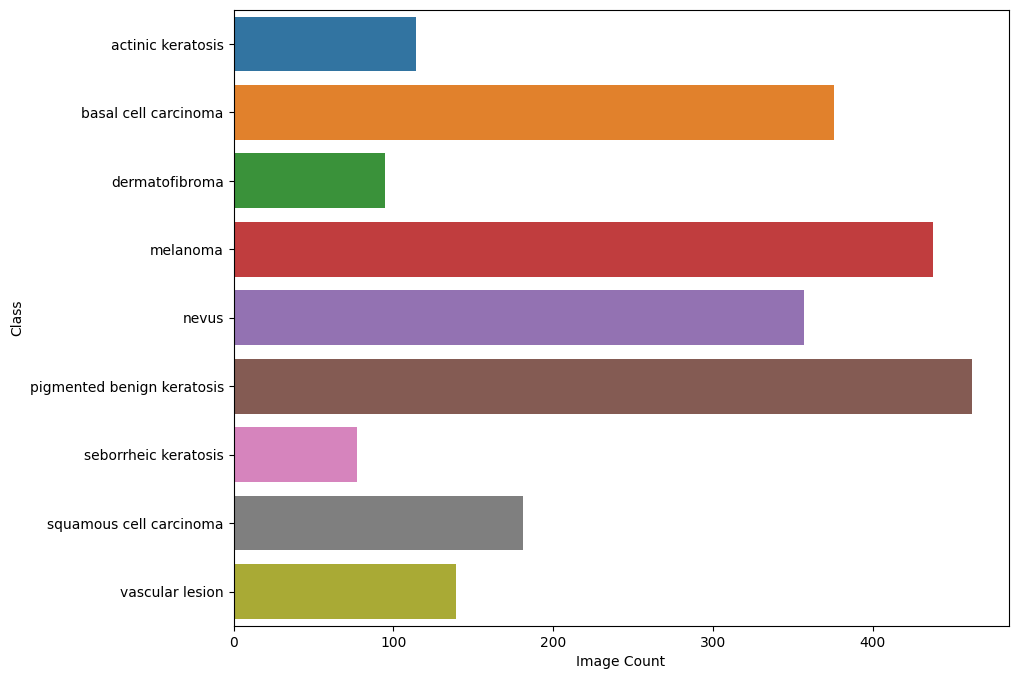

In [32]:
plt.figure(figsize=(10,8))
sns.barplot(data=Images_by_Count_df, x="Image Count", y="Class", label="Class")
plt.show()

This shows that there is an imbalance in the training dataset as data doen't carry similar number of samples in all the classes. Hence, let us use Augmentor library to add more sample across all the classes.

#### Below are few findings:
#### - Which class has the least number of samples?
→ We can see that the class `seborrheic keratosis` has least number of samples.
#### - Which classes dominate the data in terms proportionate number of samples?
→ The class `pigmented benign keratosis` is dominating the data in terms of proportionate number of samples.

## Rectifying the Class imbalance

In [33]:
# Let us install the Augmentor library
!pip install Augmentor

In [34]:
import Augmentor

In [35]:
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train) + '/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A722B923C40>: 100%|██████████| 500/500 [00:18<00:00, 27.19 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A727C5D6350>: 100%|██████████| 500/500 [00:16<00:00, 29.88 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A727C833730>: 100%|██████████| 500/500 [00:17<00:00, 29.37 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A726810CCD0>: 100%|██████████| 500/500 [01:33<00:00,  5.34 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x7A722B996B30>: 100%|██████████| 500/500 [01:17<00:00,  6.47 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A727F7AADD0>: 100%|██████████| 500/500 [00:17<00:00, 28.70 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A726DFB7940>: 100%|██████████| 500/500 [00:41<00:00, 12.16 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A727F7AB0D0>: 100%|██████████| 500/500 [00:17<00:00, 28.63 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A726416B040>: 100%|██████████| 500/500 [00:18<00:00, 26.57 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

Let us check the Image Count by Augmentor

In [38]:
len(list(data_dir_train.glob('*/output/*.jpg')))

4500

### Lets see the distribution of augmented data after adding new images to the original training data.

In [39]:
count2 = []

for path in pathlib.Path(data_dir_train).iterdir():
    if path.is_dir():
        count2.append(len([name for name in os.listdir(str(path) + '/output/')
                            if os.path.isfile(os.path.join(str(path) + '/output/', name))]))

sub_directory2 = [name + "/output" for name in os.listdir(data_dir_train)
    if os.path.isdir(os.path.join(data_dir_train, name))]

<strong>Original Training Image count</strong>

In [40]:
count

[114, 376, 95, 438, 357, 462, 77, 181, 139]

<strong>New Image count created by Augmentor</strong>

In [41]:
count2

[500, 500, 500, 500, 500, 500, 500, 500, 500]

<strong>New combined Image count</strong>

In [42]:
count3 = [sum(x) for x in zip(count,count2)]
count3

[614, 876, 595, 938, 857, 962, 577, 681, 639]

In [43]:
sub_directory2

['actinic keratosis/output',
 'basal cell carcinoma/output',
 'dermatofibroma/output',
 'melanoma/output',
 'nevus/output',
 'pigmented benign keratosis/output',
 'seborrheic keratosis/output',
 'squamous cell carcinoma/output',
 'vascular lesion/output']

Let us create a DataFrame based on training data + the data created by  Augmentation and view the barchart

                        Class  Image Count
0           actinic keratosis          614
1        basal cell carcinoma          876
2              dermatofibroma          595
3                    melanoma          938
4                       nevus          857
5  pigmented benign keratosis          962
6        seborrheic keratosis          577
7     squamous cell carcinoma          681
8             vascular lesion          639


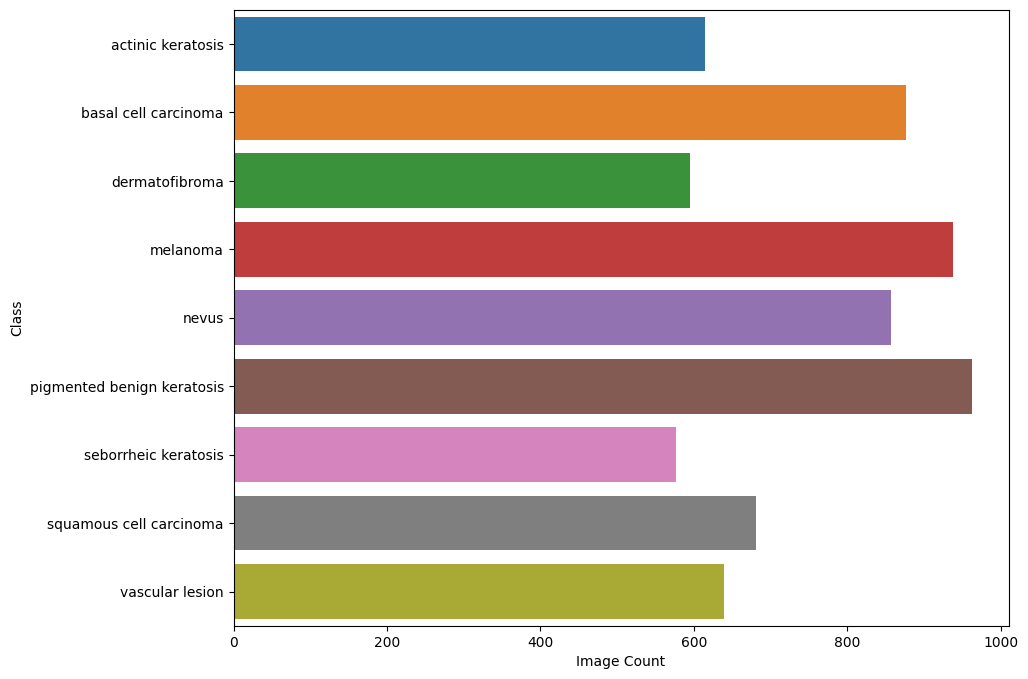

In [44]:
Images_by_Count_Augdf = pd.DataFrame(list(zip(sub_directory,count3)),columns=["Class","Image Count"])
print(Images_by_Count_Augdf)
plt.figure(figsize=(10,8))
sns.barplot(data=Images_by_Count_Augdf, x="Image Count", y="Class", label="Class")
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Let us use the training + Augmented dataset to view the first instance of all the classes

In [45]:
files_path_dict2 = {}

for c in class_names:
    files_path_dict2[c+'/output'] = list(map(lambda x:str(data_dir_train)+'/'+c+'/output/'+x,os.listdir(str(data_dir_train)+'/'+c+'/output')))

files_path_dict2

{'actinic keratosis/output': ['/content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026149.jpg_edf1ee06-6051-4919-9f11-25f5d5039e77.jpg',
  '/content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026650.jpg_12388b53-b828-4415-a0fd-8e8e09909aae.jpg',
  '/content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029900.jpg_a9593808-0abf-4e61-a1ff-1c0eecdad904.jpg',
  '/content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026525.jpg_a267207a-e67b-4ea7-b53c-59b69c6b5475.jpg',
  '/content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The Internation

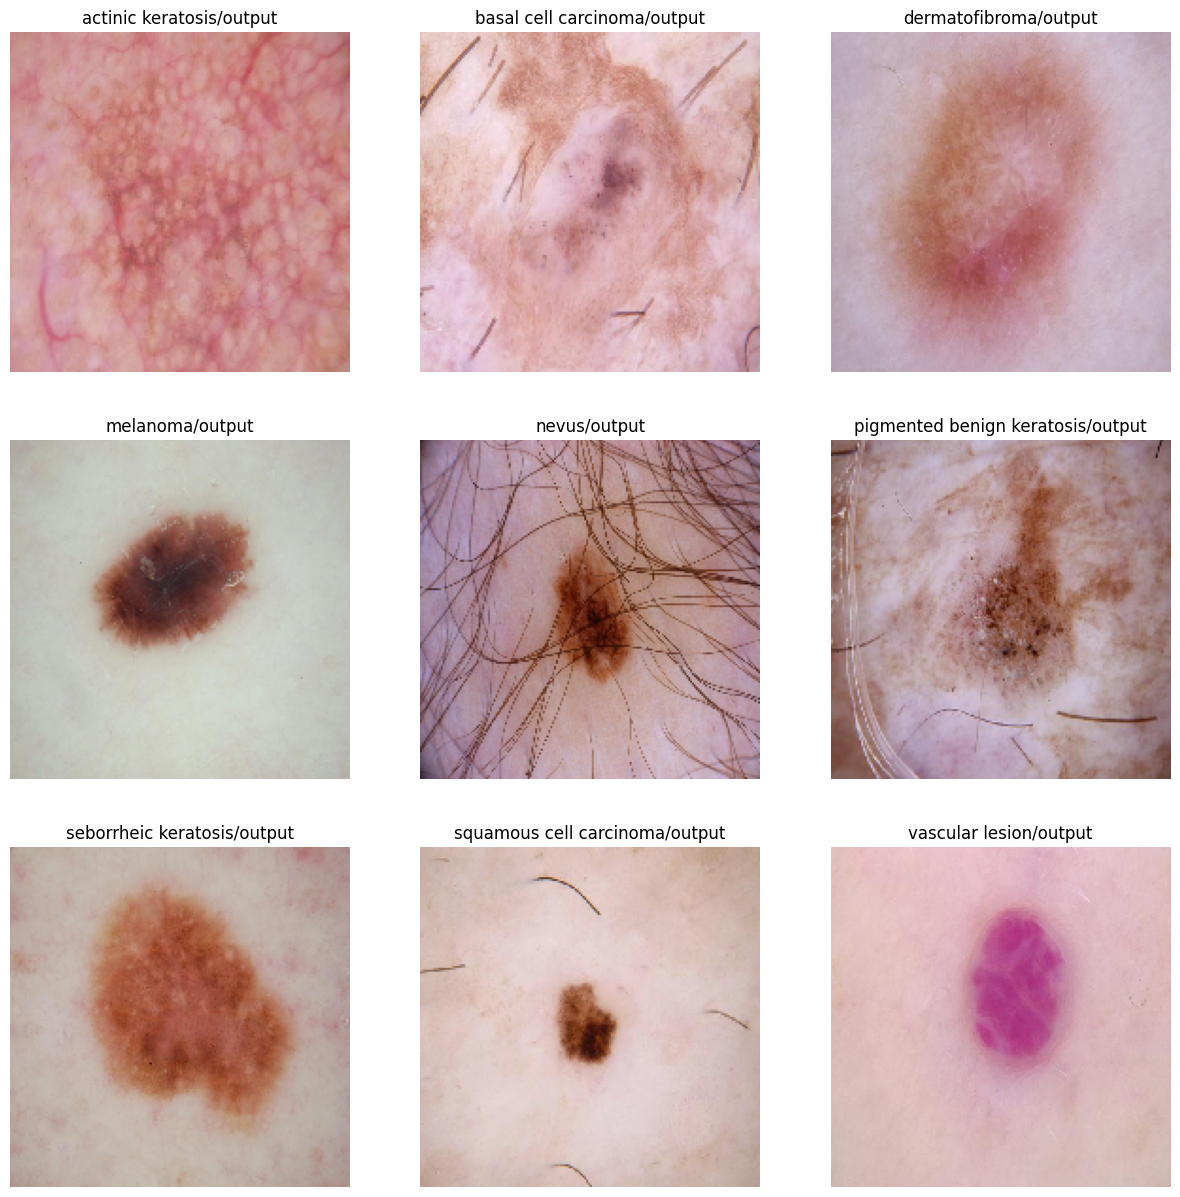

In [47]:
# Let us print one image from all the classes
plt.figure(figsize=(15,15))
index = 0
for c in files_path_dict2:
    path_list = files_path_dict2[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(keras.preprocessing.image.load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

## Train the model on the data created using Training Data + Data created by Augmentor

### Creating Dataset

#### Creating Training Dataset

In [48]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split = 0.2,
                                                               subset = 'training',
                                                               image_size=(my_img_height, my_img_width),
                                                               batch_size=my_batch_size,
                                                               label_mode='categorical')

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating Validation Dataset

In [51]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split = 0.2,
                                                             subset = 'validation',
                                                             image_size=(my_img_height, my_img_width),
                                                             batch_size=my_batch_size,
                                                             label_mode='categorical')

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Creating a Model

In [52]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))

model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Dropout(0.5))

model.add(layers.Flatten())

model.add(layers.Dense(128,activation='relu'))

model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))

### Compile a Model

In [53]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 128)      

### Training a Model

In [54]:
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 43s 241ms/step - loss: 2.1051 - accuracy: 0.1945 - val_loss: 1.8390 - val_accuracy: 0.3192
Epoch 2/30
169/169 [==============================] - 34s 197ms/step - loss: 1.6065 - accuracy: 0.3941 - val_loss: 1.4172 - val_accuracy: 0.4321
Epoch 3/30
169/169 [==============================] - 37s 211ms/step - loss: 1.4553 - accuracy: 0.4470 - val_loss: 1.2932 - val_accuracy: 0.5167
Epoch 4/30
169/169 [==============================] - 34s 198ms/step - loss: 1.3261 - accuracy: 0.4957 - val_loss: 1.2969 - val_accuracy: 0.4863
Epoch 5/30
169/169 [==============================] - 36s 202ms/step - loss: 1.2310 - accuracy: 0.5286 - val_loss: 1.1149 - val_accuracy: 0.5679
Epoch 6/30
169/169 [==============================] - 35s 200ms/step - loss: 1.0988 - accuracy: 0.5836 - val_loss: 1.0378 - val_accuracy: 0.5984
Epoch 7/30
169/169 [==============================] - 36s 202ms/step - loss: 1.0189 - accuracy: 0.6167 - val_loss: 0.9663 - val_ac

## Visualizing the model results

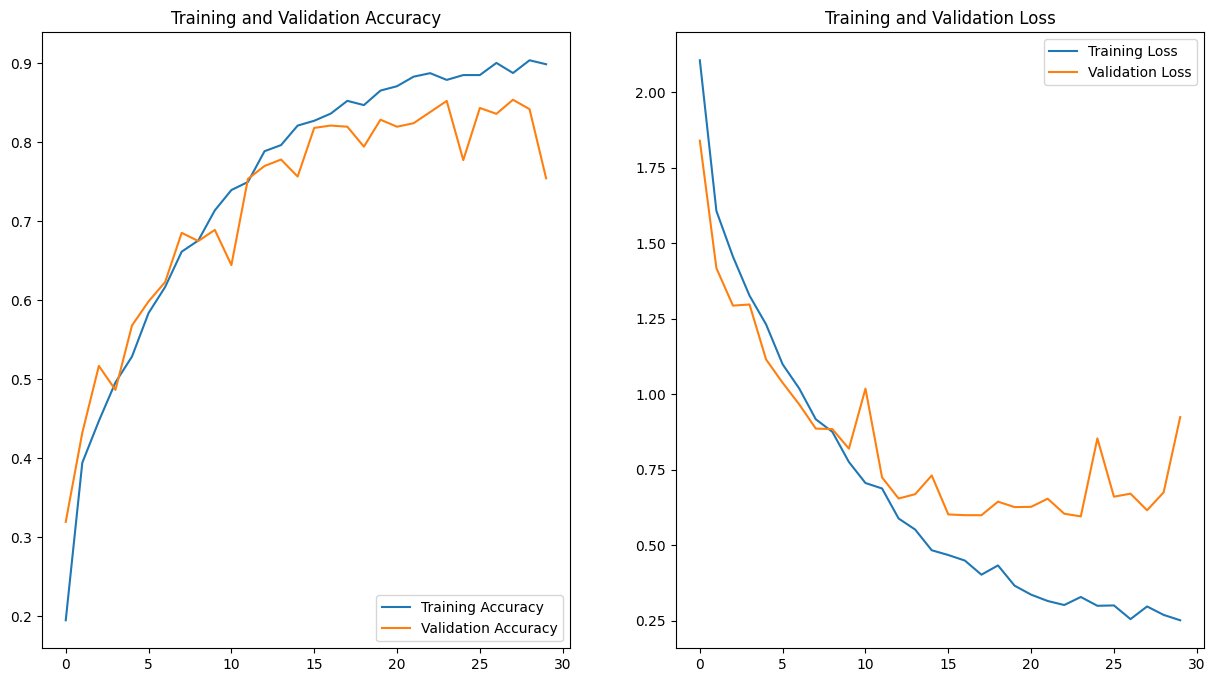

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<strong>Observation</strong>: <br/>
* We can see that the overfitting problem has been resolved by managing the imbalance in the training data. <br/>
* Model is showing similar results in traning and validation data

## Model Prediction

### Let us check the prediction with the any one test image from 'vascular lesion' class.

In [68]:
os.path.join(data_dir_test, class_names[1], '*')

'/content/gdrive/MyDrive/Dataset/Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Test/basal cell carcinoma/*'

1/1 [==============================] - 0s 36ms/step
Actual Class vascular lesion
Predictive Class vascular lesion


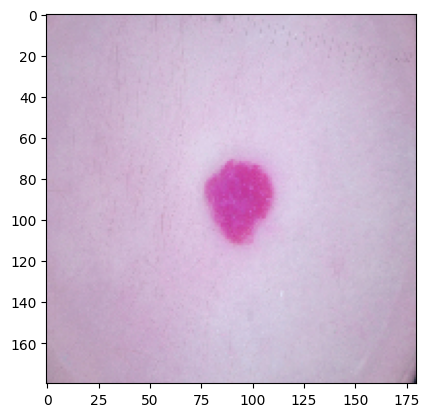

In [69]:
Test_image_path = os.path.join(data_dir_test, class_names[8], '*')
Test_image = glob(Test_image_path)
Test_image = keras.preprocessing.image.load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[8] +'\n'+ "Predictive Class "+pred_class )

### Let us check the prediction with the any one test image from 'melanoma' class.

1/1 [==============================] - 0s 28ms/step
Actual Class melanoma
Predictive Class melanoma


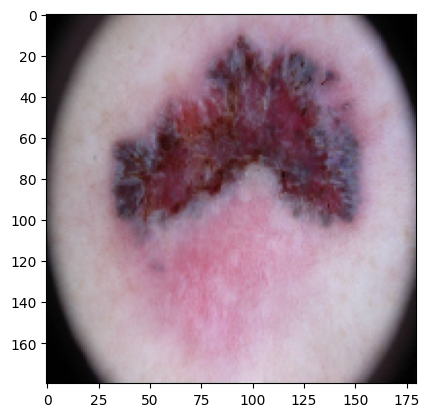

In [70]:
Test_image_path = os.path.join(data_dir_test, class_names[3], '*')
Test_image = glob(Test_image_path)
Test_image = keras.preprocessing.image.load_img(Test_image[0],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[3] +'\n'+ "Predictive Class "+pred_class )